# UAS MATKUL Machine Learning Kelompok 5
Anggota Kelompok :
- 432022611051 / Naufal Harits Prasetia
- 432022611030 / Mohamad Farhat
- 432022611003 / Alvin Arya Pangestu

# Import file dataset dari **G.Drive**
Untuk Dataset nya bisa download [disini](https://drive.google.com/drive/folders/1JqDEyxX0cusTmbEX-PllSHWPtRlbM1t8?usp=sharing)
kemudian upload di google drive anda , dan jangan lupa untuk menyesuaikan PATH didalam kode dengan PATH yang anda miliki


In [ ]:
# menyambungkan g.collabs dengan g.drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Library

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

#
import keras
from tensorflow.keras.utils import load_img, img_to_array
from keras.models import Model
from keras.applications import imagenet_utils
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from IPython.display import Image
#
from keras.layers import Dense,GlobalAveragePooling2D
# Image Generator
from keras.preprocessing.image import ImageDataGenerator
# earlyStopping
from keras.callbacks import EarlyStopping
# capture image
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

## Deklarasi / PemBuatan Fungsi

In [ ]:
# fungsi mengambil gambar dari webcam
def take_photo(filename='fotopercobaan.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
# Membuat Fungsi agar hasil prediksi nya bisa berupa output teks yang bisa dibaca
def prediksi_ke_teks(prediksi):
    """
    Fungsi ini mengubah output prediksi dari model menjadi label teks.

    Parameter:
    prediksi (numpy array): Array prediksi dari model, di mana prediksi berbentuk one-hot encoding.

    Returns:
    str: Label prediksi dalam bentuk teks.
    """
    # Mapping angka ke label
    label_map = {0: "Scissor", 1: "Paper", 2: "Rock"}

    # Menemukan indeks dari prediksi yang bernilai tertinggi
    predicted_index = np.argmax(prediksi)

    # Mengakses label berdasarkan indeks prediksi
    predicted_label = label_map[predicted_index]

    # Mengembalikan hasil prediksi dalam bentuk teks
    return f"Gambar diatas diprediksi adalah {predicted_label}"

# Cek Isi Dari Folder Dataset

In [ ]:
# Sesuaikan path dengan direktori g.drive masing-masing
!ls "/content/drive/MyDrive/Colab Notebooks/dataset/rockpaperscissors"
drive_dir_name = "/content/drive/MyDrive/Colab Notebooks/dataset/rockpaperscissors"
train_dir = drive_dir_name
validation_dir = '/content/drive/MyDrive/Colab Notebooks/dataset/validation'
test_dir = '/content/drive/MyDrive/Colab Notebooks/dataset/testing'
classes = os.listdir(train_dir)
classes

1scissors  2paper  3rock


['1scissors', '2paper', '3rock']

In [ ]:
# buat variabel per class
paper_dir = os.path.join(drive_dir_name,'2paper')
rock_dir = os.path.join(drive_dir_name,'3rock')
scissors_dir = os.path.join(drive_dir_name,'1scissors')
# hitung jumlah masing2 data
jumlahBatu =len(os.listdir(rock_dir))
jumlahKertas =len(os.listdir(paper_dir))
jumlahGunting = len(os.listdir(scissors_dir))
jumlahSemua =jumlahBatu+jumlahKertas+jumlahGunting
# Print
print("1. Scissors :", jumlahGunting)
print("2. Paper :", jumlahKertas)
print("3. Rock :", jumlahBatu)
print("Semua data trainning:", jumlahSemua)

1. Scissors : 550
2. Paper : 512
3. Rock : 526
Semua data trainning: 1588


In [ ]:
# buat variabel per class
scissors_dir = os.path.join(validation_dir,'1scissors')
paper_dir = os.path.join(validation_dir,'2paper')
rock_dir = os.path.join(validation_dir,'3rock')
# hitung jumlah masing2 data
jumlahBatu =len(os.listdir(rock_dir))
jumlahKertas =len(os.listdir(paper_dir))
jumlahGunting = len(os.listdir(scissors_dir))
jumlahSemua =jumlahBatu+jumlahKertas+jumlahGunting
# Print
print("Rock :", jumlahBatu)
print("Paper :", jumlahKertas)
print("Scissors :", jumlahGunting)
print("Semua data Validation:", jumlahSemua)

Rock : 150
Paper : 150
Scissors : 150
Semua data Validation: 450


In [ ]:
# buat variabel per class
scissors_dir = os.path.join(test_dir,'1scissors')
paper_dir = os.path.join(test_dir,'2paper')
rock_dir = os.path.join(test_dir,'3rock')
# hitung jumlah masing2 data
jumlahBatu =len(os.listdir(rock_dir))
jumlahKertas =len(os.listdir(paper_dir))
jumlahGunting = len(os.listdir(scissors_dir))
jumlahSemua =jumlahBatu+jumlahKertas+jumlahGunting
# Print
print("Rock :", jumlahBatu)
print("Paper :", jumlahKertas)
print("Scissors :", jumlahGunting)
print("Semua data Testing:", jumlahSemua)

Rock : 50
Paper : 50
Scissors : 50
Semua data Testing: 150


# MobileNet Model

In [ ]:
myModel = keras.applications.mobilenet.MobileNet(input_shape=(150,150,3),weights='imagenet',include_top=False)

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
# arsitektur mobileNet tanpat Top Layer
myModel.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 75, 75, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 75, 75, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 75, 75, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 75, 75, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 75, 75, 32) 

In [ ]:
# Menambah / Modifikasi sendiri model
x=myModel.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
x=Dense(512,activation='relu')(x)
y=Dense(3,activation='softmax')(x)

# Model baru setelah ditambahkan layer-layer diatas
myNewModel=Model(inputs=myModel.input,outputs=y)

In [ ]:
# Arsitektur Model MobileNet yang baru tadi setelah di modifikasi sedikit
myNewModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 75, 75, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 75, 75, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 75, 75, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 75, 75, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 75, 75, 32)        128   

In [ ]:
for i,layer in enumerate(myNewModel.layers):
  print(i,layer.name)

0 input_1
1 conv1
2 conv1_bn
3 conv1_relu
4 conv_dw_1
5 conv_dw_1_bn
6 conv_dw_1_relu
7 conv_pw_1
8 conv_pw_1_bn
9 conv_pw_1_relu
10 conv_pad_2
11 conv_dw_2
12 conv_dw_2_bn
13 conv_dw_2_relu
14 conv_pw_2
15 conv_pw_2_bn
16 conv_pw_2_relu
17 conv_dw_3
18 conv_dw_3_bn
19 conv_dw_3_relu
20 conv_pw_3
21 conv_pw_3_bn
22 conv_pw_3_relu
23 conv_pad_4
24 conv_dw_4
25 conv_dw_4_bn
26 conv_dw_4_relu
27 conv_pw_4
28 conv_pw_4_bn
29 conv_pw_4_relu
30 conv_dw_5
31 conv_dw_5_bn
32 conv_dw_5_relu
33 conv_pw_5
34 conv_pw_5_bn
35 conv_pw_5_relu
36 conv_pad_6
37 conv_dw_6
38 conv_dw_6_bn
39 conv_dw_6_relu
40 conv_pw_6
41 conv_pw_6_bn
42 conv_pw_6_relu
43 conv_dw_7
44 conv_dw_7_bn
45 conv_dw_7_relu
46 conv_pw_7
47 conv_pw_7_bn
48 conv_pw_7_relu
49 conv_dw_8
50 conv_dw_8_bn
51 conv_dw_8_relu
52 conv_pw_8
53 conv_pw_8_bn
54 conv_pw_8_relu
55 conv_dw_9
56 conv_dw_9_bn
57 conv_dw_9_relu
58 conv_pw_9
59 conv_pw_9_bn
60 conv_pw_9_relu
61 conv_dw_10
62 conv_dw_10_bn
63 conv_dw_10_relu
64 conv_pw_10
65 conv_pw_1

In [ ]:
for layer in myNewModel.layers[:86]: # layer 0 sampai dengan 85 non trainable
    layer.trainable=False
for layer in myNewModel.layers[86:]: # layer 86 sampai dengan terakhir
    layer.trainable=True


# Prepocessing Image

In [ ]:
# train_set=ImageDataGenerator(preprocessing_function=preprocess_input)
train_set=ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,       # Rotasi gambar dalam rentang 20 derajat
    width_shift_range=0.2,   # Pergeseran horizontal maksimum 20% dari lebar gambar
    height_shift_range=0.2,  # Pergeseran vertikal maksimum 20% dari tinggi gambar
    shear_range=0.2,         # Pergeseran geser maksimum 20 derajat
    zoom_range=0.2,          # Zoom gambar maksimum 20%
    horizontal_flip=True,    # Pembalikan horizontal acak
    fill_mode='nearest',     # Metode pengisian untuk piksel baru setelah pergeseran atau rotasi
    # preprocessing_function=preprocess_input  # Normalisasi menggunakan fungsi preprocess_input dari model yang digunakan
)

train_set2=train_set.flow_from_directory(
    directory=train_dir,
    target_size=(150,150),
    color_mode='rgb',
    batch_size=10,
    class_mode='categorical',
    shuffle=True)

Found 1588 images belonging to 3 classes.


In [ ]:
# val_set=ImageDataGenerator(preprocessing_function=preprocess_input)
val_set=ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,    # Pembalikan horizontal acak
)

val_set2=val_set.flow_from_directory(
    directory=validation_dir,
    target_size=(150,150),
    color_mode='rgb',
    batch_size=10,
    class_mode='categorical',
    shuffle=True)

Found 450 images belonging to 3 classes.


In [ ]:
test_set=ImageDataGenerator(
    rescale=1./255,
)

test_set2=test_set.flow_from_directory(
    directory=test_dir,
    target_size=(150,150),
    color_mode='rgb',
    batch_size=10,
    class_mode='categorical',
    shuffle=True)

Found 150 images belonging to 3 classes.


# Latih Model dengan Dataset

In [ ]:
# Optimizer
opt = keras.optimizers.Adam(learning_rate=0.001)
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode="auto", patience=6, restore_best_weights=True)
#
myNewModel.compile(optimizer=opt,loss="categorical_crossentropy",metrics=['accuracy'])
cobaHistory = myNewModel.fit(train_set2,epochs=10,batch_size=10,validation_data=val_set2, callbacks=[early_stopping])

Epoch 1/10
159/159 [==============================] - 416s 3s/step - loss: 0.1979 - accuracy: 0.9383 - val_loss: 0.0200 - val_accuracy: 0.9933
Epoch 2/10
159/159 [==============================] - 52s 324ms/step - loss: 0.0660 - accuracy: 0.9767 - val_loss: 0.0430 - val_accuracy: 0.9889
Epoch 3/10
159/159 [==============================] - 53s 331ms/step - loss: 0.1061 - accuracy: 0.9723 - val_loss: 0.0090 - val_accuracy: 0.9956
Epoch 4/10
159/159 [==============================] - 49s 309ms/step - loss: 0.0496 - accuracy: 0.9824 - val_loss: 0.0057 - val_accuracy: 0.9956
Epoch 5/10
159/159 [==============================] - 51s 318ms/step - loss: 0.0258 - accuracy: 0.9924 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 6/10
159/159 [==============================] - 53s 332ms/step - loss: 0.0436 - accuracy: 0.9874 - val_loss: 0.0160 - val_accuracy: 0.9933
Epoch 7/10
159/159 [==============================] - 51s 320ms/step - loss: 0.0423 - accuracy: 0.9861 - val_loss: 0.0013 - val_accu

In [ ]:
# Evaluasi model
loss, accuracy = myNewModel.evaluate(test_set2)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

15/15 [==============================] - 37s 3s/step - loss: 0.0108 - accuracy: 0.9933
Test Loss: 0.01083544921129942
Test Accuracy: 0.9933333396911621


15/15 [==============================] - 6s 367ms/step
[[17 19 14]
 [16 14 20]
 [17 18 15]]
              precision    recall  f1-score   support

   1scissors       0.34      0.34      0.34        50
      2paper       0.27      0.28      0.28        50
       3rock       0.31      0.30      0.30        50

    accuracy                           0.31       150
   macro avg       0.31      0.31      0.31       150
weighted avg       0.31      0.31      0.31       150



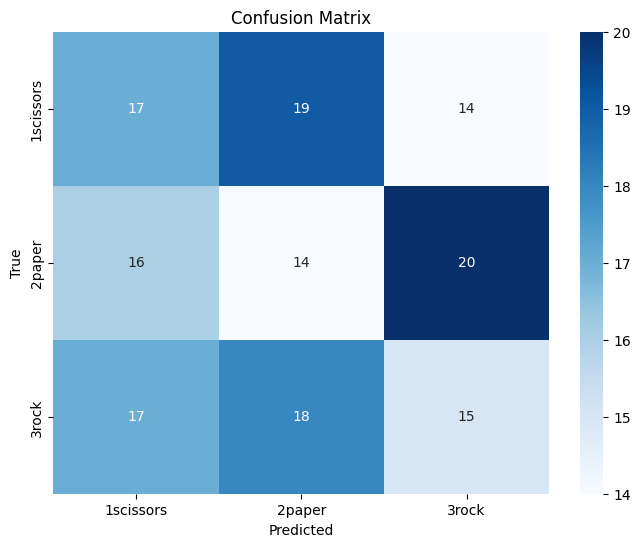

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Buat prediksi
y_pred = myNewModel.predict(test_set2)
y_pred_classes = np.argmax(y_pred, axis=1)  # Mengambil indeks kelas prediksi dengan probabilitas tertinggi
y_true = test_set2.classes  # Label sebenarnya

# Menghitung confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print(conf_matrix)

# Menampilkan classification report
class_labels = list(test_set2.class_indices.keys())
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print(report)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot


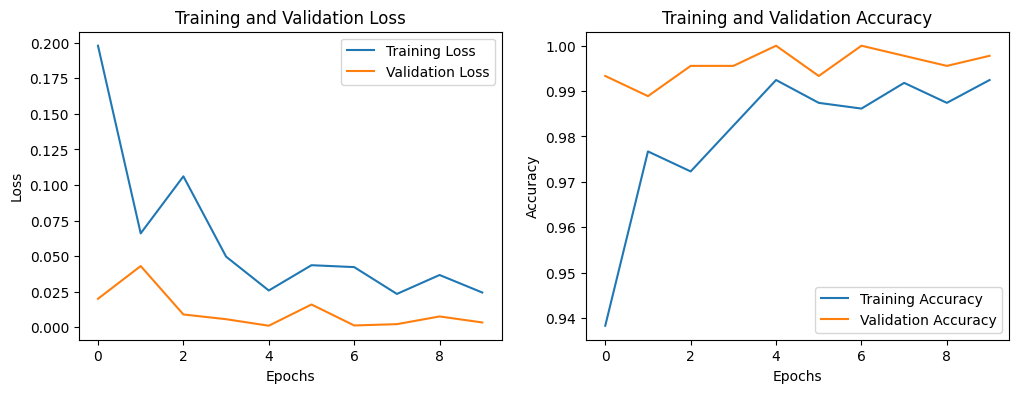

In [ ]:
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(cobaHistory.history['loss'], label='Training Loss')
plt.plot(cobaHistory.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Akurasi
plt.subplot(1, 2, 2)
plt.plot(cobaHistory.history['accuracy'], label='Training Accuracy')
plt.plot(cobaHistory.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

# Prediksi Gambar

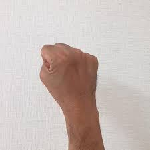

In [ ]:
# Taruh/Upload Gambar Manual pada G.Collabs kemudian sesuai kan PATH nya
img = keras.utils.load_img('/content/batutest1.jpeg', target_size=(150, 150))
img_array = keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
gambar = keras.applications.mobilenet.preprocess_input(img_array)
img

In [ ]:
# Prediksi
predictions = model_baru.predict(gambar)
predictions

1/1 [==============================] - 0s 36ms/step


array([[0.03876743, 0.13283816, 0.82839435]], dtype=float32)

In [ ]:
# penggunaan fungsi
hasilPredict = np.round(predictions)
hasil_teks = prediksi_ke_teks(hasilPredict) # panggil fungsi prediksi_ke_teks()
print(hasil_teks)

Gambar diatas diprediksi adalah Rock


# Save Model / Export Model

In [ ]:
myNewModel.save('myNewModel.h5')

# Percobaan Pengaplikasian Model menggunakan Webcam


## Camera Capture
Using a webcam to capture images for processing on the runtime.

<IPython.core.display.Javascript object>

Saved to fotopercobaan.jpg


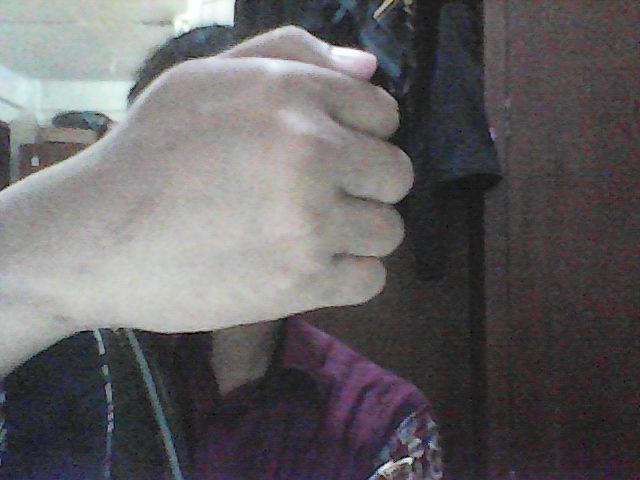

In [ ]:
# AMBIL GAMBAR DARI WEBCAM
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## Test Foto yang baru diambil

ukuran = (150, 150)


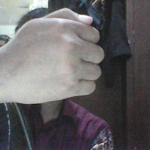

In [ ]:
testCam = keras.utils.load_img('/content/fotopercobaan.jpg')
# Crop & Resize
width, height = testCam.size
left=np.round((width-height)/2)
right=left+height
testCam = testCam.crop((left, 0, right, height))
testResize = testCam.resize((150,150))
print(f'ukuran = {testResize.size}')
testResize

In [ ]:
# Taruh/Upload Gambar Manual pada G.Collabs kemudian sesuai kan PATH nya
cameraCapt = testResize
cam_array = keras.utils.img_to_array(cameraCapt)
cam_array = np.expand_dims(cam_array, axis=0)
captureResult = keras.applications.mobilenet.preprocess_input(cam_array)

# Prediksi
predictions2 = model_baru.predict(captureResult)
predictions2

1/1 [==============================] - 0s 36ms/step


array([[0.10642243, 0.15532716, 0.73825043]], dtype=float32)

In [ ]:
# penggunaan fungsi
hasilPredict2 = np.round(predictions2)
hasil_teks2 = prediksi_ke_teks(hasilPredict2)
print(hasil_teks2)

Gambar diatas diprediksi adalah Rock


# Note :
evaluasi :
-